In [1]:
# =========================
# 1. Install dependencies
# =========================
!pip install -U openai numpy pandas scipy tabulate matplotlib

In [2]:
# =========================
# 2. Import library
# =========================
import os
import time
import json
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from openai import OpenAI
from scipy.stats import norm
from tabulate import tabulate

In [15]:
# =========================================================
# 2.Configure DeepSeek API
# =========================================================

from openai import OpenAI
from google.colab import userdata
import random
import numpy as np

DEEPSEEK_API_KEY = userdata.get("DEEPSEEK_API_KEY")

if not DEEPSEEK_API_KEY:
    raise ValueError("DEEPSEEK_API_KEY is empty. Please set it in Colab Secrets first.")

client = OpenAI(
    api_key=DEEPSEEK_API_KEY,
    base_url="https://api.deepseek.com"
)

MODEL_NAME = "deepseek-chat"

print("DeepSeek client ready")
print("model:", MODEL_NAME)
print("key length:", len(DEEPSEEK_API_KEY))
print("key prefix:", DEEPSEEK_API_KEY[:5])

DeepSeek client ready
model: deepseek-chat
key length: 35
key prefix: sk-bb


In [4]:
# =========================================================
# 3. Global Experimental Parameters
# =========================================================

# Start with a small-scale test to facilitate assignment submission and debugging.
N_LIST = [1, 3]
BLOCKS = 2

# If you want to make the result more stable later, you can change it to:
# BLOCKS = 5

ALPHABET = "bcdfghjklnpqrstvwxyz"
SEQ_LENGTH = 24
MATCHES = 8

RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

print("N_LIST =", N_LIST)
print("BLOCKS =", BLOCKS)
print("SEQ_LENGTH =", SEQ_LENGTH)
print("MATCHES =", MATCHES)

N_LIST = [1, 3]
BLOCKS = 2
SEQ_LENGTH = 24
MATCHES = 8


In [5]:
# =========================
# Generate verbal n-back sequences
# =========================
def generate_nback_sequences(n, alphabet, seq_length, matches, num_sequences):
    sequences = []

    for _ in range(num_sequences):
        seq = []
        conditions = []

        match_positions = random.sample(range(n, seq_length), matches)
        match_positions.sort()

        for i in range(seq_length):
            if i in match_positions:
                # Forced construction of match
                seq.append(seq[i - n])
                conditions.append("m")
            else:
                # Construct a non-match to avoid unexpected n-back matches.
                random_letter = random.choice(alphabet)
                while i >= n and random_letter == seq[i - n]:
                    random_letter = random.choice(alphabet)

                seq.append(random_letter)
                conditions.append("-")

        sequences.append(("".join(seq), "".join(conditions)))

    return sequences


def build_all_trials(n_list, blocks, alphabet, seq_length, matches):
    all_trials = {}

    for n in n_list:
        sequences = generate_nback_sequences(
            n=n,
            alphabet=alphabet,
            seq_length=seq_length,
            matches=matches,
            num_sequences=blocks
        )

        for b, (seq, cond) in enumerate(sequences):
            trials = []
            for i in range(len(seq)):
                trials.append({
                    "stimulus": seq[i],
                    "target": cond[i],
                    "response": "",
                    "correct": None,
                    "rt": None
                })

            all_trials[f"{n}back_{b}"] = trials

    return all_trials


all_trials = build_all_trials(
    n_list=N_LIST,
    blocks=BLOCKS,
    alphabet=ALPHABET,
    seq_length=SEQ_LENGTH,
    matches=MATCHES
)

print("Data preparation complete.")
print("Keys example:", list(all_trials.keys())[:3])

Data preparation complete.
Keys example: ['1back_0', '1back_1', '3back_0']


In [6]:
# =========================
# 5. DeepSeek function calls (stable version)
# =========================
def normalize_response(text):
    """
    Try to normalize the model output to 'm' or '-'.
    """
    if text is None:
        return None

    text = str(text).strip().lower()

    # Exact Match
    if text == "m":
        return "m"
    if text == "-":
        return "-"

    # Common multiple output scenarios
    text = text.replace(" ", "")
    if text.startswith("m"):
        return "m"
    if text.startswith("-"):
        return "-"

    # Iterate through the list to find the first valid character
    for ch in text:
        if ch in ["m", "-"]:
            return ch

    return None


def get_model_response(messages, model_name, temperature, max_retries=3, sleep_seconds=2):
    if "client" not in globals():
        raise ValueError("The client has not been initialized yet. Please run the API configuration section first.")

    last_error = None

    for attempt in range(max_retries):
        try:
            start_time = time.time()

            completion = client.chat.completions.create(
                model=model_name,
                messages=messages,
                temperature=temperature,
                max_tokens=5
            )

            response_time = time.time() - start_time
            raw_text = completion.choices[0].message.content
            response = normalize_response(raw_text)

            return response, raw_text, response_time

        except Exception as e:
            last_error = e
            print(f"[API ERROR] attempt {attempt+1}/{max_retries}: {e}")
            time.sleep(sleep_seconds)

    raise RuntimeError(f"The API kept failing, eventually resulting in an error.：{last_error}")

In [7]:
# =========================
# 6. Run a single n-back task (stable version)
# =========================
def run_nback_task(all_trials, n, blocks, model_name, temperature, output_file, sleep_between_blocks=1):
    if n == 1:
        task_instruction = (
            "You are asked to perform a 1-back task. "
            "You will see a sequence of letters one by one. "
            "Respond with 'm' whenever the current letter is the same as the previous letter, "
            "and '-' otherwise. Only output 'm' or '-'. No explanation."
        )
    elif n == 2:
        task_instruction = (
            "You are asked to perform a 2-back task. "
            "You will see a sequence of letters one by one. "
            "Respond with 'm' whenever the current letter is the same as the letter two steps ago, "
            "and '-' otherwise. Only output 'm' or '-'. No explanation."
        )
    elif n == 3:
        task_instruction = (
            "You are asked to perform a 3-back task. "
            "You will see a sequence of letters one by one. "
            "Respond with 'm' whenever the current letter is the same as the letter three steps ago, "
            "and '-' otherwise. Only output 'm' or '-'. No explanation."
        )
    else:
        raise ValueError("Currently only supports n=1/2/3")

    for b in range(blocks):
        trial_key = f"{n}back_{b}"
        messages = [{"role": "system", "content": task_instruction}]

        print(f"\n========== Running {trial_key} ==========")

        for i, trial in enumerate(all_trials[trial_key]):
            stimulus = trial["stimulus"]
            target = trial["target"]

            print(f"block {b}, trial {i}: stimulus={stimulus}, target={target}")

            messages.append({"role": "user", "content": stimulus})

            try:
                response, raw_text, rt = get_model_response(
                    messages=messages,
                    model_name=model_name,
                    temperature=temperature
                )

                trial["rt"] = rt
                trial["raw_output"] = raw_text

                # If the parsing still fails, provide a default value to avoid interrupting the entire experiment.
                if response not in ["m", "-"]:
                    print(f"[WARNING] Unable to recognize output，raw={raw_text}，Default is recorded as '-'")
                    response = "-"

                trial["response"] = response
                trial["correct"] = (response == target)

                print(f"model raw: {raw_text}")
                print(f"parsed: {response}")
                print(f"rt: {rt:.2f}s")
                print("correct" if trial["correct"] else "incorrect")
                print("------------------------------------")

                messages.append({"role": "assistant", "content": response})

            except Exception as e:
                print(f"[TRIAL ERROR] block {b}, trial {i}: {e}")

                trial["rt"] = None
                trial["raw_output"] = str(e)
                trial["response"] = "ERROR"
                trial["correct"] = False

                # To avoid interrupting the entire experiment, a default answer is added to the context.
                messages.append({"role": "assistant", "content": "-"})

        # Save the code after each block to prevent data loss if the process is interrupted.
        with open(output_file, "w", encoding="utf-8") as f:
            json.dump(all_trials, f, ensure_ascii=False, indent=2)

        print(f"[AUTO-SAVED] {output_file}")
        time.sleep(sleep_between_blocks)

    return all_trials

In [8]:
# =========================================================
# 7. Statistical Results
# =========================================================

def compute_summary_stats(all_trials, n_list, blocks):
    summary_stats = {}
    raw_data = {}

    for n in n_list:
        hit_rate = []
        false_alarm_rate = []
        accuracy = []
        response_time = []
        d_prime = []

        for b in range(blocks):
            trials = all_trials[f"{n}back_{b}"]

            hits = 0
            false_alarms = 0
            total_targets = 0
            total_lures = 0
            total_rt = 0

            for trial in trials:
                if trial["target"] == "m":
                    total_targets += 1
                    if trial["correct"]:
                        hits += 1
                        if trial["rt"] is not None:
                            total_rt += trial["rt"]
                else:
                    total_lures += 1
                    if trial["response"] == "m":
                        false_alarms += 1

            hr = (hits / total_targets) * 100 if total_targets > 0 else np.nan
            far = (false_alarms / total_lures) * 100 if total_lures > 0 else np.nan
            acc = ((hits + (total_lures - false_alarms)) / (total_targets + total_lures)) * 100

            hit_rate_adjusted = np.clip(hits / total_targets, 0.01, 0.99) if total_targets > 0 else np.nan
            false_alarm_rate_adjusted = np.clip(false_alarms / total_lures, 0.01, 0.99) if total_lures > 0 else np.nan

            if not np.isnan(hit_rate_adjusted) and not np.isnan(false_alarm_rate_adjusted):
                dp = abs(norm.ppf(hit_rate_adjusted) - norm.ppf(false_alarm_rate_adjusted))
            else:
                dp = np.nan

            mean_rt = total_rt / hits if hits > 0 else np.nan

            hit_rate.append(hr)
            false_alarm_rate.append(far)
            accuracy.append(acc)
            response_time.append(mean_rt)
            d_prime.append(dp)

        raw_data[n] = {
            "hit_rate": hit_rate,
            "false_alarm_rate": false_alarm_rate,
            "accuracy": accuracy,
            "response_time": response_time,
            "d_prime": d_prime
        }

        summary_stats[n] = {
            "hit_rate": {
                "mean": np.nanmean(hit_rate),
                "stderr": np.nanstd(hit_rate, ddof=1) / math.sqrt(blocks) if blocks > 1 else 0
            },
            "false_alarm_rate": {
                "mean": np.nanmean(false_alarm_rate),
                "stderr": np.nanstd(false_alarm_rate, ddof=1) / math.sqrt(blocks) if blocks > 1 else 0
            },
            "accuracy": {
                "mean": np.nanmean(accuracy),
                "stderr": np.nanstd(accuracy, ddof=1) / math.sqrt(blocks) if blocks > 1 else 0
            },
            "d_prime": {
                "mean": np.nanmean(d_prime),
                "stderr": np.nanstd(d_prime, ddof=1) / math.sqrt(blocks) if blocks > 1 else 0
            }
        }

    return summary_stats, raw_data


def create_summary_table(summary_stats, n_list):
    headers = ["N-back", "Hit Rate (%)", "False Alarm Rate (%)", "Accuracy (%)", "D Prime"]
    rows = []

    for n in n_list:
        rows.append([
            f"{n}-back",
            f"{summary_stats[n]['hit_rate']['mean']:.2f} ± {summary_stats[n]['hit_rate']['stderr']:.2f}",
            f"{summary_stats[n]['false_alarm_rate']['mean']:.2f} ± {summary_stats[n]['false_alarm_rate']['stderr']:.2f}",
            f"{summary_stats[n]['accuracy']['mean']:.2f} ± {summary_stats[n]['accuracy']['stderr']:.2f}",
            f"{summary_stats[n]['d_prime']['mean']:.2f} ± {summary_stats[n]['d_prime']['stderr']:.2f}",
        ])

    df = pd.DataFrame(rows, columns=headers)
    print(tabulate(df.values, headers=df.columns, tablefmt="github"))
    return df

In [9]:
# =========================================================
# 8. Plotting function
# =========================================================

def plot_accuracy(summary_stats, n_list, model_name, temperature):
    x = [str(n) for n in n_list]
    y = [summary_stats[n]["accuracy"]["mean"] for n in n_list]
    yerr = [summary_stats[n]["accuracy"]["stderr"] for n in n_list]

    plt.figure(figsize=(6, 4))
    plt.bar(x, y, yerr=yerr)
    plt.xlabel("N-back")
    plt.ylabel("Accuracy (%)")
    plt.title(f"Verbal N-Back Accuracy ({model_name}, temp={temperature})")
    plt.show()

In [10]:
# =========================================================
# 9. Run a single experiment (one temperature).
# =========================================================

def run_experiment_for_temperature(temperature, model_name, n_list, blocks):
    output_file = f"all_trials_verbal_temp{temperature}.json"

    print("\n" + "=" * 60)
    print(f"开始运行实验：temperature = {temperature}")
    print("=" * 60)

# Regenerate the same set of trial structures for each temperature

# Note: To ensure reproducibility, the seed is fixed again.
    random.seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)

    all_trials = build_all_trials(
        n_list=n_list,
        blocks=blocks,
        alphabet=ALPHABET,
        seq_length=SEQ_LENGTH,
        matches=MATCHES
    )

    for n in n_list:
        all_trials = run_nback_task(
            all_trials=all_trials,
            n=n,
            blocks=blocks,
            model_name=model_name,
            temperature=temperature,
            output_file=output_file,
            sleep_between_blocks=1
        )

    with open(output_file, "w", encoding="utf-8") as f:
        json.dump(all_trials, f, ensure_ascii=False, indent=2)

    print(f"\nThe experiment is complete, and the results have been saved to: {output_file}")

    summary_stats, raw_data = compute_summary_stats(all_trials, n_list, blocks)
    summary_df = create_summary_table(summary_stats, n_list)
    plot_accuracy(summary_stats, n_list, model_name, temperature)

    return {
        "temperature": temperature,
        "output_file": output_file,
        "all_trials": all_trials,
        "summary_stats": summary_stats,
        "summary_df": summary_df,
        "raw_data": raw_data
    }

In [11]:
# =========================================================
# 10. First, run a minimal API test (it's recommended to run it first).
# =========================================================

test_messages = [
    {"role": "system", "content": "Reply with only m or -."},
    {"role": "user", "content": "x"}
]

completion = client.chat.completions.create(
    model=MODEL_NAME,
    messages=test_messages,
    temperature=0,
    max_tokens=5
)

print("API test output:", completion.choices[0].message.content)

API test output: -



开始运行实验：temperature = 1

========== Running 1back_0 ==========
block 0, trial 0: stimulus=x, target=-
model raw: -
parsed: -
rt: 1.20s
correct
------------------------------------
block 0, trial 1: stimulus=x, target=m
model raw: m
parsed: m
rt: 1.30s
correct
------------------------------------
block 0, trial 2: stimulus=d, target=-
model raw: -
parsed: -
rt: 1.60s
correct
------------------------------------
block 0, trial 3: stimulus=y, target=-
model raw: -
parsed: -
rt: 1.43s
correct
------------------------------------
block 0, trial 4: stimulus=y, target=m
model raw: m
parsed: m
rt: 1.02s
correct
------------------------------------
block 0, trial 5: stimulus=y, target=m
model raw: m
parsed: m
rt: 1.54s
correct
------------------------------------
block 0, trial 6: stimulus=s, target=-
model raw: -
parsed: -
rt: 1.46s
correct
------------------------------------
block 0, trial 7: stimulus=c, target=-
model raw: -
parsed: -
rt: 1.14s
correct
------------------------------------
b

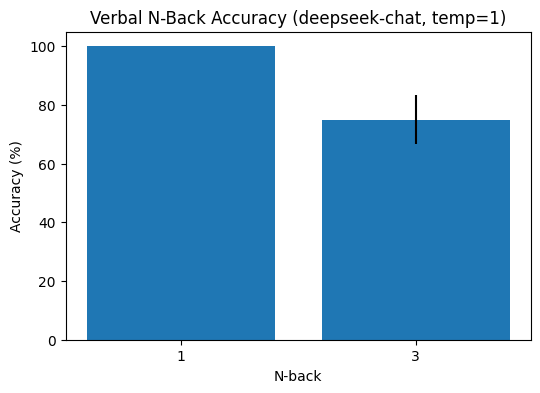


开始运行实验：temperature = 0

========== Running 1back_0 ==========
block 0, trial 0: stimulus=x, target=-
model raw: -
parsed: -
rt: 1.73s
correct
------------------------------------
block 0, trial 1: stimulus=x, target=m
model raw: -
parsed: -
rt: 1.91s
incorrect
------------------------------------
block 0, trial 2: stimulus=d, target=-
model raw: -
parsed: -
rt: 1.66s
correct
------------------------------------
block 0, trial 3: stimulus=y, target=-
model raw: -
parsed: -
rt: 1.41s
correct
------------------------------------
block 0, trial 4: stimulus=y, target=m
model raw: m
parsed: m
rt: 1.49s
correct
------------------------------------
block 0, trial 5: stimulus=y, target=m
model raw: m
parsed: m
rt: 1.46s
correct
------------------------------------
block 0, trial 6: stimulus=s, target=-
model raw: -
parsed: -
rt: 1.79s
correct
------------------------------------
block 0, trial 7: stimulus=c, target=-
model raw: -
parsed: -
rt: 1.47s
correct
------------------------------------

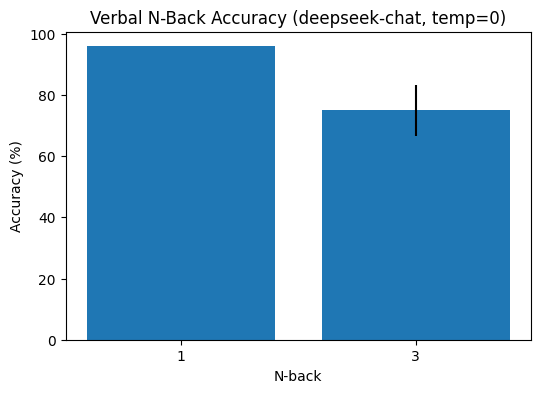

In [12]:
# =========================================================
# 11. Conduct two sets of experiments.
#     baseline: temp = 1
#     modification: temp = 0
# =========================================================

result_temp1 = run_experiment_for_temperature(
    temperature=1,
    model_name=MODEL_NAME,
    n_list=N_LIST,
    blocks=BLOCKS
)

result_temp0 = run_experiment_for_temperature(
    temperature=0,
    model_name=MODEL_NAME,
    n_list=N_LIST,
    blocks=BLOCKS
)

In [13]:
# =========================================================
# 12. Compare temp=1 vs temp=0
# =========================================================

def compare_two_temperatures(result_temp1, result_temp0, n_list):
    rows = []

    for n in n_list:
        acc_t1 = result_temp1["summary_stats"][n]["accuracy"]["mean"]
        acc_t0 = result_temp0["summary_stats"][n]["accuracy"]["mean"]
        dp_t1 = result_temp1["summary_stats"][n]["d_prime"]["mean"]
        dp_t0 = result_temp0["summary_stats"][n]["d_prime"]["mean"]

        rows.append([
            f"{n}-back",
            round(acc_t1, 2),
            round(acc_t0, 2),
            round(acc_t0 - acc_t1, 2),
            round(dp_t1, 2),
            round(dp_t0, 2)
        ])

    df_compare = pd.DataFrame(
        rows,
        columns=["N-back", "Temp=1 Accuracy", "Temp=0 Accuracy", "Accuracy Delta", "Temp=1 D′", "Temp=0 D′"]
    )

    print(tabulate(df_compare.values, headers=df_compare.columns, tablefmt="github"))
    return df_compare

df_compare = compare_two_temperatures(result_temp1, result_temp0, N_LIST)
df_compare

| N-back   |   Temp=1 Accuracy |   Temp=0 Accuracy |   Accuracy Delta |   Temp=1 D′ |   Temp=0 D′ |
|----------|-------------------|-------------------|------------------|-------------|-------------|
| 1-back   |               100 |             95.83 |            -4.17 |        4.65 |        3.48 |
| 3-back   |                75 |             75    |             0    |        1.16 |        1.16 |


,N-back,Temp=1 Accuracy,Temp=0 Accuracy,Accuracy Delta,Temp=1 D′,Temp=0 D′
0,1-back,100.0,95.83,-4.17,4.65,3.48
1,3-back,75.0,75.00,0.00,1.16,1.16


In [14]:
# =========================================================
# 13. If you want to save the compare table as a CSV
# =========================================================

df_compare.to_csv("temp_comparison_table.csv", index=False, encoding="utf-8-sig")
print("Saved: temp_comparison_table.csv")

Saved: temp_comparison_table.csv
